# Проект 04. Исследование данных о поведении пользователей сервиса аренды самокатов GoFast.

В вашем распоряжении данные сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках. 
необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:   
    •	без подписки          
           •	абонентская плата отсутствует;        
           •	стоимость одной минуты поездки — 8 рублей;         
           •	стоимость старта (начала поездки) — 50 рублей;        
    •	с подпиской Ultra          
           •	абонентская плата — 199 рублей в месяц;         
           •	стоимость одной минуты поездки — 6 рублей;         
           •	стоимость старта — бесплатно.


### Оглавление:

Шаг 1. Загрузка данных        

Шаг 2. Предобработка данных       

Шаг 3. Исследовательский анализ данных      

Шаг 4. Объединение данных       

Шаг 5. Подсчёт выручки       

Шаг 6. Проверка гипотез       

Общий вывод

Шаг 7 (необязательное задание). Распределения       

## Шаг 1. Загрузка данных

In [1]:
import matplotlib.pyplot as plt
from scipy import stats as st
from math import sqrt
import pandas as pd
import numpy as np

### 1.1 Считать CSV-файлы с данными с помощью библиотеки pandas и сохранить их в датафреймы.

In [2]:
try:
    go_users = pd.read_csv('users_go.csv')
    go_subscriptions = pd.read_csv('subscriptions_go.csv')
    go_rides = pd.read_csv('rides_go.csv')

except:
    go_users = pd.read_csv('/datasets/users_go.csv')
    go_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
    go_rides = pd.read_csv('/datasets/rides_go.csv')

### 1.2 Вывести первые строки каждого набора данных. Изучить общую информацию о каждом датафрейме.

Посмотрим на датафрейм с данными о пользователях 

In [3]:
go_users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
go_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Видим:
1. Датафрейм содержит 1565 строк (клиентов), по каждому - 5 столбцов (параметров).     
2. Данные в столбцах, как и говорилось в описании: 'user_id', 'name', 'age', 'city' и 'subscription_type'.      
user_id - единственный параметр, по которому теоретически можно проверить дубликаты (если они есть), поскольку остальные столбцы принципиально непроверяемы. Параметр в столбце идет по возрастанию без пропусков, что по всей видимости значит, что дубликатов здесь нет. Но проверить стоит.
Из этого датафрейма нам в дальнейшем точно понадобятся данные о типе подписки и о городе.         
3. Количество строк во всех стлбцах одинаково, по всей видимости пропусков нет.            
4. Типы данных, продекларированные в dtype соответствуют сути данных, здесь менять ничего не нужно; если в процессе для удобства анализа потребуется поменять гдн-то тип - будем смотреть по месту.

Посмотрим основную информацию о численных столбцах. С пожалуй единственной целью - посмотреть нет ли каких-то нереальных возрастов

In [5]:
go_users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


Старшее поколение не очень то катается на самокатах.

Посмотрим на еще один справочник - датафрейм с данными о подписках

In [6]:
go_subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
go_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Видим:
1. В этом справочнике все совсем просто: датафрейм содержит всего 2 строки, по каждой - 4 столбца.     
2. Данные в столбцах, как и говорилось в описании: ‘subscription_type’ - тип подписки, ‘minute_price’ - стоимость одной минуты поездки по данной подписке, ‘start_ride_price’ - стоимость начала поездки, ‘subscription_fee’ - стоимость ежемесячного платежа. Значения в трех последним столбцах приведены в рублях, без копеек, что соответствует отписанию. Все цифры тоже соответствуют тем, которые заявлялись в описании проекта.        
3. Количество строк во всех стлбцах по две, значит пропусков нет.            
4. Типы данных, продекларированные в dtype соответствуют сути данных, здесь менять ничего не нужно.
5. Пересечение с датасетом 'users' - по столбцу 'subscription_type'.

Здесь отдельно смотреть describe() совсем нет смысла - все видно сразу по самому датафрейму

Посмотрим наш "основной" датафрейм с данными о поездках

In [8]:
go_rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [9]:
go_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Видим:
1. Датафрейм содержит 18068 строк (поездок), по каждой - 4 столбца (параметры поездки).     
2. Данные в столбцах соответствуют описанию: 'user_id', 'distance' - расстояние, которое пользователь проехал в текущей сессии (в метрах), 'duration' - продолжительность сессии (в минутах) и 'date' - дата совершения поездки.             
3. Количество строк во всех стлбцах одинаково, по всей видимости пропусков нет.            
4. По типам данных: столбец 'date' необходимо перевести из типа 'object' в 'DateTime', остальные столбцы содержат типы данных, которые соответствуют сути самих данных, в них менять ничего не нужно.
5. Пересечение с датафреймом 'users' - по столбцу 'user_id'.

Посмотрим основную информацию о численных столбцах на предмет их распределения и соответствия здравому смыслу.

In [10]:
go_rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


Видим:

1. Максимальное значение 'user_id' равно 1534, что значит, что количество уникальных клиентов у нас 1534, то есть в датафрейме 'users' по всей видимости есть 31 дубликат; удалим их далее в упражнении 2.2.       
2. Данные о поездках видятся вполне адекватными: средняя дальность поездки в 3 километра - вполне нормальна, кроме того она близка к оптимальной с точки зрения износа самоката; средняя длительность поездки 18 минут соответствует скорости в 10.4 км./ч., что вполне нормально для самоката.       
3. Стандартное отклонение для дальности поездки интуитивно видится довольно большим. Кроме того медианное знаяение выше среднего. Чем это обусловлено пока непонятно, но стоит обратить внимание: а нет ли "выбросов", особенно с нижней стороны.
4. В остальном цифры достаточно ровные и по всей видимости без заметных выбросов: скорости по всей линейке от нижнего квартиля и до максимума отличаются всего максимум на 0.2 км/ч.

## Шаг 2. Предобработка данных

### 2.1 Привести столбец date к типу даты pandas.

Посмотрим на столбец 'date' в датафрейме 'rides': тип данных в нем object, формат даты %Y-%m-%d.    
Преобразуем его в datetime

In [11]:
go_rides['date'] = pd.to_datetime(go_rides['date'], format= '%Y-%m-%d')

go_rides.dtypes  # Проверка: тип данных в столбце "date" должен быть datetime64

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

Тип данных в столбце 'date' теперь datetime

### 2.2 Создать новый столбец с номером месяца на основе столбца date.

In [12]:
go_rides['month'] = go_rides['date'].dt.month

display(go_rides.head(5))  # Проверка: посмотреть визуально появился ли нужный столбец и что в нем за значения
go_rides['month'].dtype  # Проверка: у столбца должен быть формат int64 или int32

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


dtype('int64')

Новый столбец 'month' создался, данные в нем соответствуют номеру месяца, который фигурирует в той же строке в столбце 'date'

Удостоверимся, что данные за один и тот же год, чтобы данные за разные годы не склеились в одни и те же месяцы

In [13]:
go_rides_year = go_rides['date'].dt.year

go_rides_year.value_counts()  # Проверка: посмотреть визуально появился ли нужный столбец и что в нем за значения

2021    18068
Name: date, dtype: int64

Можно еще так

In [109]:
# Код ревьюера
go_rides['date'].dt.year.unique()

array([2021])

Итак, все данные у нас за один 2021 год, поэтому объединение их по месяцам можно считать корректным

### 2.3 Проверить наличие пропущенных значений и дубликатов в датафреймах и обработать их, если такие значения присутствуют

Проверим наличие пропусков и дубликатов в датафрейме 'users'

In [14]:
go_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Оказывается info() не врет: пропусков нет

In [15]:
go_users.duplicated().sum()

31

Как мы и предполагали глядя на максимальный "user_id" в датафрейме 'rides' - дубликаты есть и их ровно 31. То есть уникальных клиентов у нас должно быть 1534. 

От дубликатов нужно будет избавиться, удалим их 

In [16]:
go_users = go_users.drop_duplicates().reset_index(drop=True)

go_users.info()  # Проверка: количество строк должно быть одинаково во всех столбцах и равно 1534

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


Проверим наличие пропусков и дубликатов в датафрейме 'subscriptions'

In [17]:
go_subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [18]:
go_subscriptions.duplicated().sum()

0

В этом датафрейме дубликатов как и пропусков - нет

Проверим наличие пропусков и дубликатов в датафрейме 'rides'

In [19]:
go_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [20]:
go_rides.duplicated().sum()

0

И в этом датафрейме дубликатов и пропусков тоже нет.

Таким образом пропусков и явных дубликатов ни в одном из трех датафреймов нет.     

Относительно неявных дубликатов:       
в принципе они могли бы быть в связи с неправильным написанием строк в столбце 'subscription_type' датафрейма 'subscriptions' и столбцов 'name' и 'city' датафрейма 'users'.    
Но по виду датафрейма 'subscriptions' выше видно, что проблем со значениями типов подписок нет: значения два - free (отсутствие подписки) и ultra (наличие подписки ультра).     
По датафрейму 'users':     
явные дубликаты мы здесь удалили;      
проверять столбец с именем клиента бесполезно - имена могут быть сколько угодно одинаковыми или разными, а реально клиенты идентифицируются по 'user_id';
то, что разных user_id нет - понятно из users.info() чуть выше: их 1534 (столько же, сколько и в датафрейме с поездками), можно еще раз явным образом вывести список уникальных значений user_id, но там будет то же самое;      
а если кто-то зарегистрирован несколько раз под разными user_id - мы сделать ничего не можем и вынуждены считать его разными клиентами

In [21]:
go_users['user_id'].unique()

array([   1,    2,    3, ..., 1532, 1533, 1534])

Поэтому единственным местом, где могут "скрываться" неявные дубликаты и которое мы еще не смотрели - это столбец 'city' датафрейма 'users'.             
Посмотрим уникальные значения этого столбца

In [22]:
go_users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Наименования городов все прописаны нормально.      
Если сложить количества упоминаний всех городов, то получим все то же значение 1534, то есть нигде ничего "не затерялось".

Таким образом скрытых и неявных дубликатов ни в одном из трех датафреймов тоже нет.     

## Шаг 3. Исследовательский анализ данных

### Описать и визуализировать общую информацию о пользователях и поездках:

### 3.1 частота встречаемости городов.

Города у нас упоминаются в датафрейме 'users'.     
Частоту их встречаемости среди клиентов мы видели только что, в процессе поиска скрытых дубликатов.      
Повторим еще раз.

In [23]:
city_occurrence = go_users['city'].value_counts()

city_occurrence

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Выведем основные статистические параметры встречаемости.

In [24]:
city_occurrence.describe()

count      8.000000
mean     191.750000
std       15.672998
min      168.000000
25%      182.250000
50%      191.000000
75%      199.500000
max      219.000000
Name: city, dtype: float64

И визуализируем столбчатой диаграммой.

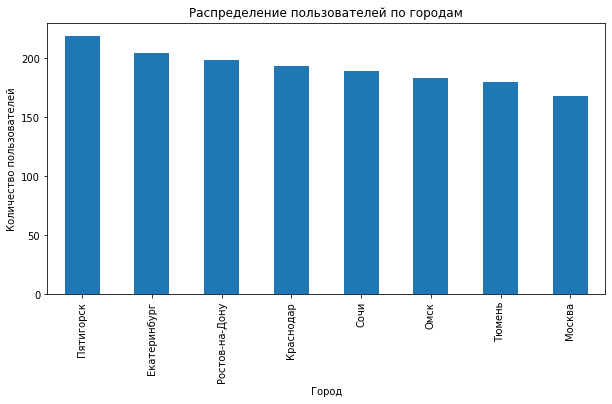

In [25]:
city_occurrence.plot.bar( figsize = (10,5))
plt.title('Распределение пользователей по городам')
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.show()

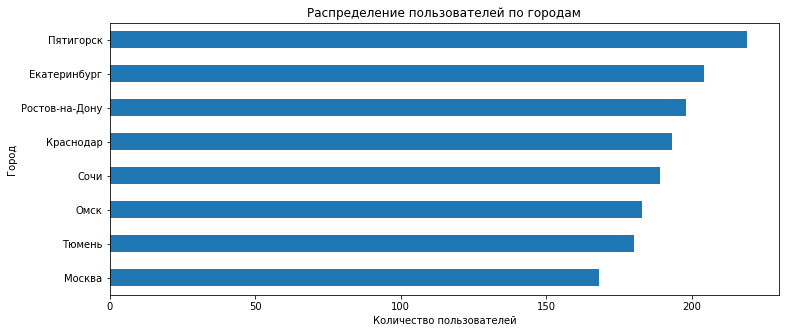

In [115]:
go_users['city'].value_counts(ascending = True).plot(kind = 'barh', figsize = (12, 5))
plt.title('Распределение пользователей по городам')
plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.show()

Видим:

1. Нам переданы данные о клиентах компании в восьми городах.
2. Клиенты распределены по городам довольно ровно: в среднем по 191-192 человека в каждом.     
3. Максимальное количество клиентов в Пятигорске - 219, минимальное как ни удивительно - в Москве - 168 человек.       
4. Стандартный разброс количества клиентов по городам в пределах 10% от среднего количества, что вполне нормально. 

### 3.2 соотношение пользователей с подпиской и без подписки.

Данные о подписки упоминаются в том же датафрейме 'users': если подписка есть - то в столбце "subscription_type" этого датафрейма стоит "ultra", а если подписки нет - "free".       
Посмотрим популярность подписки среди клиентов.

In [26]:
subscription_occurrence = go_users['subscription_type'].value_counts()

subscription_occurrence

free     835
ultra    699
Name: subscription_type, dtype: int64

Cтатистические параметры в этом случае выводить нет смысла.

Визуализируем столбчатой диаграммой.

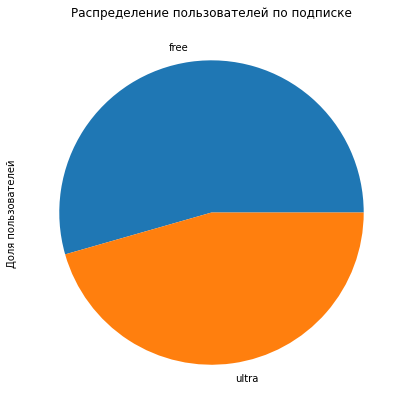

In [27]:
subscription_occurrence.plot( kind='pie', figsize = (7,7))
plt.title('Распределение пользователей по подписке')
plt.ylabel('Доля пользователей')
plt.show()

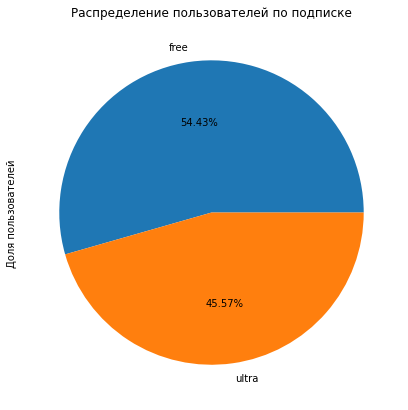

In [120]:
go_users['subscription_type'].value_counts().plot( kind='pie', figsize = (7,7), 
                                                 autopct = '%.2f%%')
plt.title('Распределение пользователей по подписке')
plt.ylabel('Доля пользователей')
plt.show()

Видим:

1. Из 1534 клиентов компании в восьми городах 699 имеют подписку "ультра" и 835 - не имеют подписки.
2. Соотношение на мой взгляд свидетельствует о том, что у компании достаточно высокий процент постоянных клиентов, однако сервисами так-же пользуются и клиенты по разовым тарифам.     
3. Данные о поездках по обеим категориям клиентов мы будем смотреть более подробно чуть позже - в ходе шага №4. 

### 3.3 возраст пользователей.

Данные о возрасте клиентов находятся в датафрейме 'users' в столбце 'age'.      
Этот столбец - единственный числовой в этом датафрейме, поэтому параметры распределения клиентов по возрастам можно было бы посмотреть просто выведя users.describe(), что мы и делали, когда проводили общий обзор этого датафрейма.
В этот раз взглянем на то, как клиенты распределены по возрастам немного по другому а заодно посмотрим основные статистические характеристики встречаемости возрастов и подготовим вывод диаграммы.

In [28]:
age_occurrence = go_users['age'].value_counts()

age_occurrence = age_occurrence.reset_index()
age_occurrence.columns = ['age','occurrence']

age_occurrence.describe()

,age,occurrence
count,29.000000,29.000000
mean,26.103448,52.896552
std,8.706914,48.824280
min,12.000000,1.000000
25%,19.000000,9.000000
50%,26.000000,41.000000
75%,33.000000,93.000000
max,43.000000,145.000000


Поскольку возраста колеблются от 12 до 43 и суммарно их не так много (всего 29) - то объединять их в группы наверное нет смысла.

Посмотрим на них всех.

In [29]:
age_occurrence= age_occurrence.sort_values('age')

age_occurrence

,age,occurrence
24,12,4
22,13,8
21,14,9
20,15,13
18,16,19
16,17,26
13,18,46
12,19,47
8,20,71
7,21,93


И визуализируем столбчатой диаграммой.

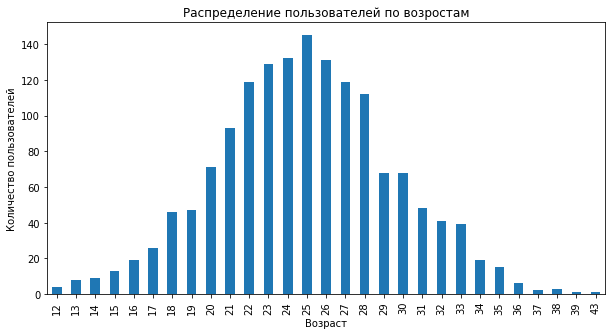

In [30]:
age_occurrence.sort_values(by='age').plot.bar( x='age', y='occurrence', legend=False, figsize = (10,5))
plt.title('Распределение пользователей по возростам')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

... или гистограммой

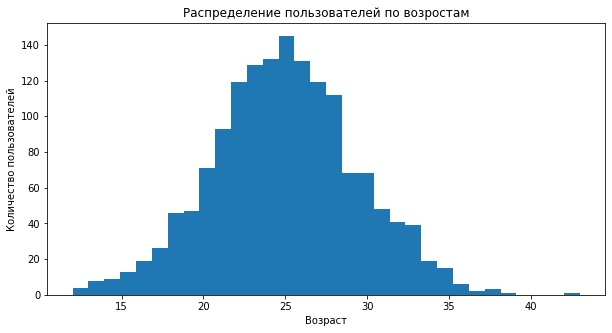

In [31]:
go_users.hist('age', bins=32, grid=False, figsize=(10,5))
plt.title('Распределение пользователей по возростам')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

Видим:

1. Возраст клиентов компании колеблется от 12 до 43 лет. Средний возраст практически совпадает с медианным и составляет 26 лет. 
2. Распределение клиентов по возрастам очень напоминает нормальное распределение. Подавляющаяя масса клиентов сосредоточены в возрастных пределах от 19 (Q1) до 33 (Q3) лет.      
3. Максимальное количество клиентов представляют 25-летние - их 145 человек. Минимальное количество - по одному человеку 39-ти и 43-х лет.      
4. Вообще клиентов старше 35 лет считанные единицы ( 36 - 6, 37 - 2, 38 - 3, 39 и 43 - по 1). Возможно чуть более старшее поколение ( > 35 лет ) может считаться перспективой для компании. 

### 3.4 расстояние, которое пользователь преодолел за одну поездку.

Данные о поездках находятся в датафрейме 'rides'; расстояние, которое клиент проехал за конкретную поездку отражена в столбце "distance" в метрах. 

Посмотрим основные статистические параметры дальности поездок ...

In [32]:
go_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

... и встречаемости разных дальностей (то есть количество поездок на конкретное расстояние)       
Поскольку расстояние, пройденное в каждой поездке, отражено в датафрейме с очень высокой точностью (тип float64), то для того, чтобы статистические параметры имели како-то смысл, понизим точность дальности поездок до какой-то разумной (например до 100 метров).  

In [33]:
distance_occurrence = round(go_rides['distance'].astype(int), -2).value_counts()

distance_occurrence = distance_occurrence.reset_index()
distance_occurrence.columns = ['distance','occurrence']

distance_occurrence['occurrence'].describe()

count     72.000000
mean     250.944444
std      265.018728
min        1.000000
25%       48.500000
50%      138.000000
75%      450.000000
max      858.000000
Name: occurrence, dtype: float64

In [34]:
distance_occurrence

,distance,occurrence
0,3000,858
1,3100,851
2,3200,835
3,3300,818
4,2800,793
...,...,...
67,6900,1
68,6600,1
69,7200,1
70,6800,1


И визуализируем 

столбчатой диаграммой...

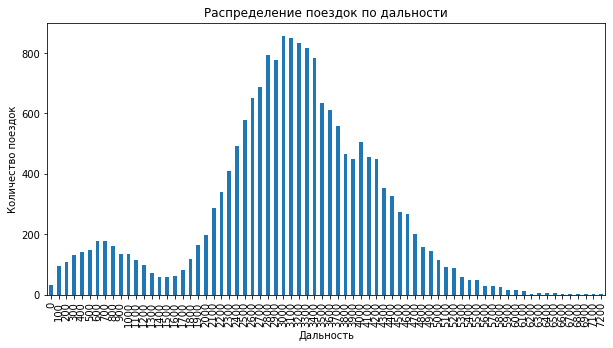

In [35]:
distance_occurrence.sort_values(by='distance').plot.bar( x='distance', y='occurrence', legend=False, figsize = (10,5))
plt.title('Распределение поездок по дальности')
plt.xlabel('Дальность')
plt.ylabel('Количество поездок')
plt.show()

... или гистограммой

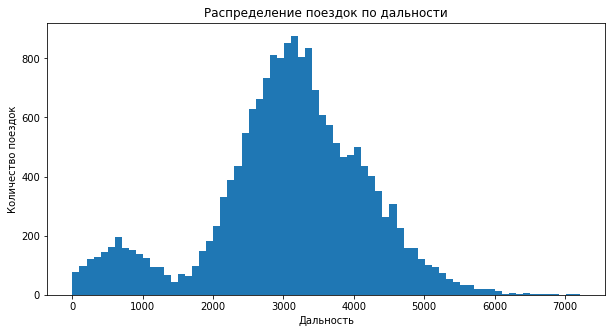

In [36]:
go_rides.hist('distance', bins=72, grid=False, figsize=(10,5))
plt.title('Распределение поездок по дальности')
plt.xlabel('Дальность')
plt.ylabel('Количество поездок')
plt.show()

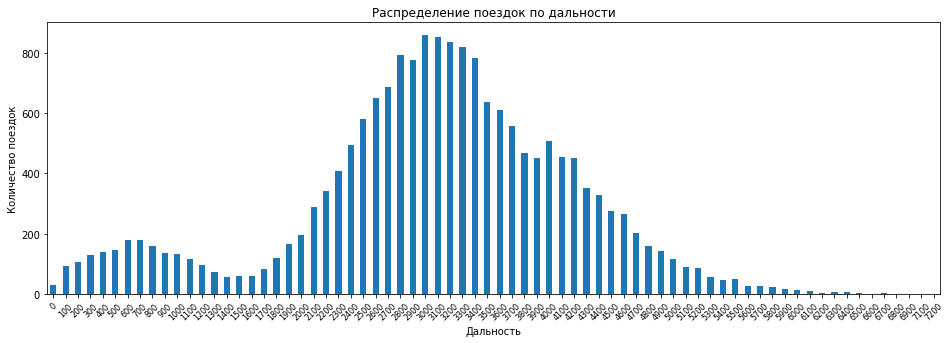

In [138]:
# Код ревьюера
distance_occurrence.sort_values(by='distance').plot.bar( x='distance', y='occurrence', legend=False, figsize = (16,5),
                                                       rot = 45) # Поворот на 45 градусов разметки
plt.title('Распределение поездок по дальности')
plt.xlabel('Дальность')
plt.xticks(fontsize = 8) # Размер шрифта разметки оси Х
plt.ylabel('Количество поездок')
plt.show()

Прежде всего отметим, что вид распределения поездок по дистанциям на диаграмме производит впечатление двух диаграмм - всплесков, наложенных одна на другую:   большую с центром где-то около 3000-3100 метров и малую с центром около 600-700 метров  
    
Перед тем, как продолжать делать выводы, посмотрим на каждый из двух диапазонов, в которых "локализованы" центры этих двух гипотетических распределений - всплесков.

In [37]:
distance_occ_low = distance_occurrence[(distance_occurrence['distance'] < 1500)]

distance_occ_low['occurrence'].sum()

1776

In [38]:
distance_occ_low['distance'].describe()

count      15.000000
mean      700.000000
std       447.213595
min         0.000000
25%       350.000000
50%       700.000000
75%      1050.000000
max      1400.000000
Name: distance, dtype: float64

Визуализируем 

столбчатой диаграммой...

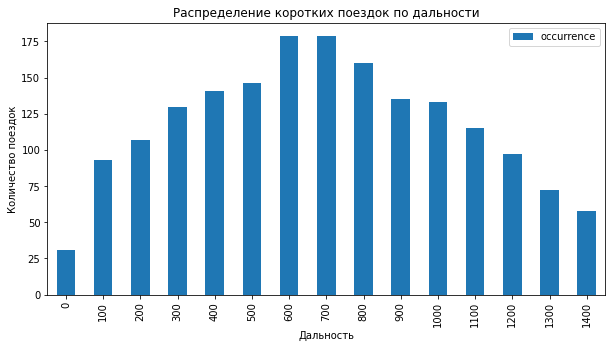

In [39]:
distance_occ_low.sort_values(by='distance').plot.bar( x='distance', y='occurrence', figsize = (10,5))
plt.title('Распределение коротких поездок по дальности')
plt.xlabel('Дальность')
plt.ylabel('Количество поездок')
plt.show()

... или гистограммой

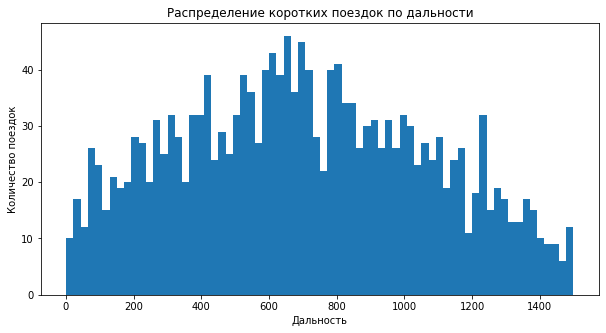

In [40]:
go_rides[go_rides['distance'] < 1500].hist('distance', bins=70, grid=False, figsize=(10,5))
plt.title('Распределение коротких поездок по дальности')
plt.xlabel('Дальность')
plt.ylabel('Количество поездок')
plt.show()

In [41]:
distance_occ_high = distance_occurrence[ (distance_occurrence['distance'] >= 1500) & (distance_occurrence['distance'] < 5000)]

distance_occ_high['occurrence'].sum()

15699

In [42]:
distance_occ_high['distance'].describe()

count      35.000000
mean     3200.000000
std      1024.695077
min      1500.000000
25%      2350.000000
50%      3200.000000
75%      4050.000000
max      4900.000000
Name: distance, dtype: float64

Визуализируем 

столбчатой диаграммой...

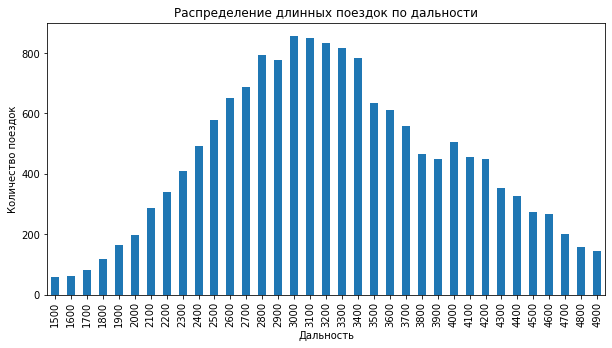

In [43]:
distance_occ_high.sort_values(by='distance').plot.bar( x='distance', y='occurrence', legend=False, figsize = (10,5))
plt.title('Распределение длинных поездок по дальности')
plt.xlabel('Дальность')
plt.ylabel('Количество поездок')
plt.show()

... или гистограммой

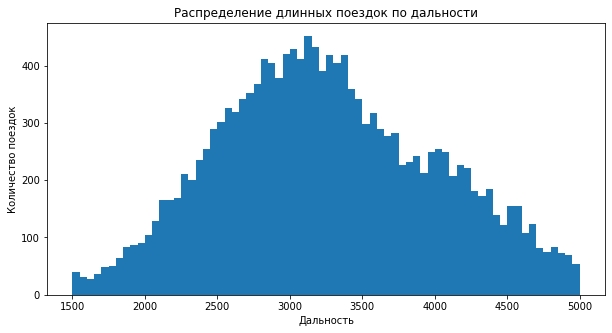

In [44]:
go_rides[(go_rides['distance'] >= 1500) & (go_rides['distance'] < 5000)].hist('distance', bins=70, grid=False, figsize=(10,5))
plt.title('Распределение длинных поездок по дальности')
plt.xlabel('Дальность')
plt.ylabel('Количество поездок')
plt.show()

In [45]:
distance_occurrence[distance_occurrence['distance'] >= 5000]['distance'].value_counts().sort_values().sum()

22

Итак, видим:

1. Ранее, при изучении общей информации по этому датафрейму мы отмечали, что данные по поездкам полны - 18068 записей, средняя дальность поездки составляет 3070 метров, что очень близко к оптимальной дистанции одной поездки с точки зрения износа самоката.      
2. Вид распределения дальности поездок действительно очень напоминает наложение двух "околонормальных распределений"
    - одно - по виду немного скошенное нормальное распределение с "центром" около 3200 метров и стандартным отклонением 1024 м. (что как кажется - довольно много.      
    - и второе тоже по виду маленькое нормальное распределение с центром около 700 метров и стандартным отклонением 447 метров. 
3. Наличие такого рода "наложения" обуславливает факт, который мы отметили ранее: что медианное знаяение выше среднего. Скошенность самих распределений обусловлена тем, что мы просто разделили их по диапазонам значений, а наложенность одного на другое имеет более сложную структуру.
Если это наличие нижнего выброса хотя бы приблизительно проявится и на диаграмме длительностей,  по всей видимости это может означать, что поездки делятся на две отличные друг от друга категории: короткие (до километра) и дальние (от полутора до пяти км.) и возможно есть смысл каким-то образом их разделять.      
4. Минимальное значение расстояния в 0.85 метра (и пол-минуты длительности) вполне соответствует кейсу "взял неисправный, он не едет - бросил" или "попробовал поехать, не получилось - бросил". Минимальные расстояния - до 100 метров встречаются в общей сложности всего 31 раз, что тоже укладывается в схему "попробовал поехать, не понравилось - бросил".    
5. Максимальное пройденное за поездку расстояние равно 7,2 км., что в принципе лежит в пределах возможного для города. Однако следует отметить, что дистанции поездок свыше 5 км. встречаются редко, в единичных количествах, суммарное количество таких поездок (свыше 5 км. каждая) - всего 22. При необходимости, в дальнейшем анализе все поездки длиннее 5 км. можно считать если не выбросами, то "хвостами" и исключить из рассмотрения.  


### 3.5 продолжительность поездок.

Данные о поездках находятся в датафрейме 'rides'; продолжительность конкретной поездку отражена в столбце "duration" в минутах.       

Посмотрим на статистические параметры продолжительности поездки...

In [46]:
go_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

... и встречаемости разных длительностей (то есть количество поездок конкретной длительности).           
В принципе в случае с длительностью поездки ситуация такая-же как и с дальностью: она представлена в датафрейме типом float64, однако если смтреть длительность с точностью до минуты, то значений получается всего 40, что вполне удобно для анализа.

In [47]:
duration_occurrence = round(go_rides['duration'].astype(int), 0).value_counts()

duration_occurrence = duration_occurrence.reset_index()
duration_occurrence.columns = ['duration','occurrence']

duration_occurrence['occurrence'].sum()

18068

In [48]:
duration_occurrence['duration'].describe()

count    40.000000
mean     20.475000
std      11.734209
min       0.000000
25%      10.750000
50%      20.500000
75%      30.250000
max      40.000000
Name: duration, dtype: float64

In [49]:
duration_occurrence

,duration,occurrence
0,18,1198
1,17,1190
2,20,1122
3,19,1119
4,15,1119
5,16,1095
6,14,1080
7,13,991
8,21,958
9,12,923


И визуализируем 

столбчатой диаграммой...

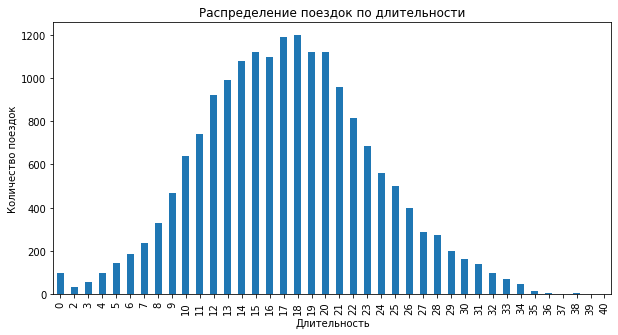

In [50]:
duration_occurrence.sort_values(by='duration').plot.bar( x='duration', y='occurrence', legend=False, figsize = (10,5))
plt.title('Распределение поездок по длительности')
plt.xlabel('Длительность')
plt.ylabel('Количество поездок')
plt.show()

Вид неожиданный.    
Ожидался равпределенный всплеск в нижней части. Видим просто одиночный всплеск в районе нуля.

Посмотрим - может закралась ошибка и гистограмма на основе начального датафрейма покажет что-то другое

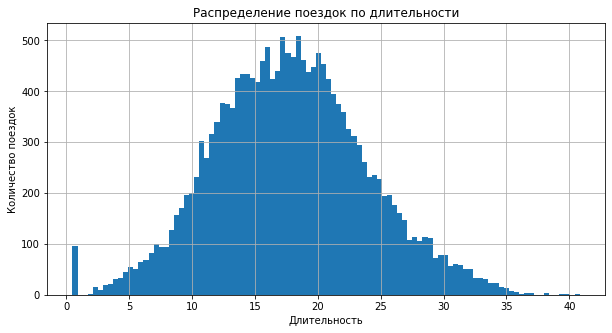

In [51]:
go_rides.hist('duration', bins=100, figsize=(10,5))
plt.title('Распределение поездок по длительности')
plt.xlabel('Длительность')
plt.ylabel('Количество поездок')
plt.show()

Вид примерно такой же: чуть заметнее всплеск около нуля, но не более того.

Посмотрим чуть подробнее самую нижнюю часть и попробуем сообразить является ли этот небольшой выброс тем самым, который может соответствовать нижнему всплеску (или наложению), которое мы отметили на диаграмме распределения дальности поездок.      
Разбирая дальность поездок мы определили, что нижний всплеск имел примерно следующие параметры: дальность от 0 до 1400 метров, средняя дальность 700 метров и количество попавших в него поездок 1779.    
Помня о том, что средняя скорость поездки равна примерно 10 км.ч, мы можем рассмотреть нижнюю часть распределения по длительности поездки от 0 до 8 минут. При этом если  в этот интервал попадут ок. 1800 поездок и их среднее будет ок. 4 минут, то выводы, которые мы сделали по распределению дальностей поездок можно будет расширить и на длительности поездок, а значит и на вообще поездки.

In [52]:
duration_occ_low = duration_occurrence[(duration_occurrence['duration'] < 9)]

duration_occ_low['occurrence'].sum()

1170

In [53]:
duration_occ_low['duration'].describe()

count    8.00000
mean     4.37500
std      2.66927
min      0.00000
25%      2.75000
50%      4.50000
75%      6.25000
max      8.00000
Name: duration, dtype: float64

Количество поездок в нижнем выбросе хоть и в полтора раза меньше, чем в аналогичном выбросе, посчитанном по расстояниям, однако их больше тысячи. Будем считать что это все-таки действительно отражение нижнего всплеска, который мы отметили на диаграмме дальности поездок. Тот факт, что количество поездок здесь меньше аналогичного показателя в распределении по дальности можно объяснить тем, что на короткие дистанции пользователи ездили существенно быстрее эти ок. 600 поездок здесь попали в основной "колокол". Чтобы это произошло скорость в таких поездках должна была бы быть ок. 20 км/ч и выше, что вполне возможно для самоката.      
А средняя время поездки полностью соответствует предположенному значению в 4 минуты.

Итак, видим:

1. Так же как и в случае с дальностью поездок данные в столбце 'duration' полны - 18068 поездок.       
2. Ранее, при изучении общей информации по этому датафрейму мы отмечали, что длительности поездок хорошо соответствуют дальности поездки - при средней скорости 10.4 км/ч, скорости по всей линейке от нижнего квартиля и до максимума отличаются всего максимум на 0.2 км/ч.       
3. Вид распределения длительности поездок очень напоминает классическое "нормальное" распределение. Тем не менее в нижней части распределения присутствует выброс, который соответствует аналогичному выбросу, обнаруженному нами на диаграмме расстояний.    Это подтверждает нашу гипотезу о том, что что поездки делятся на две отличные друг от друга категории: короткие (до километра) и дальние (от полутора до пяти км.). Продуктовикам на заметку.         
4. Минимальное значение длительности в пол-минуты соответствует неудачной попытке поехать.       
5. Максимальная длительность поездки в 40 минут хорошо соответствует максимальной дальности в 7 км., на диаграмме длительностей так же, как и на диграмме расстояний видно (хоть и чуть менее явно), что долгих дальних поездок единицы.

## Шаг 4. Объединение данных

### 4.1 Объединить данные о пользователях, поездках и подписках в один датафрейм.

Объединим датафреймы 'go_users', 'go_subscriptions' и 'go_rides' методом merge() и создадим объединенный датафрейм 'go_all'. 

Сначала объединим датафреймы 'go_users' и 'go_subscriptions' по столбцу 'subscription_type',      	
а затем объединим получившийся датафрейм с фреймом 'go_rides' по столбцу 'user_id'.

In [54]:
go_all = go_users.merge(go_subscriptions, on= 'subscription_type')
go_all = go_all.merge(go_rides, on= 'user_id')

display(go_all.head(10))  # Проверка: посмотреть глазами что получается
go_all.info()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8
5,1,Кира,22,Тюмень,ultra,6,0,199,2770.890808,16.650138,2021-10-09,10
6,1,Кира,22,Тюмень,ultra,6,0,199,3039.020292,14.927879,2021-10-19,10
7,1,Кира,22,Тюмень,ultra,6,0,199,2842.118050,23.117468,2021-11-06,11
8,1,Кира,22,Тюмень,ultra,6,0,199,3412.690668,15.238072,2021-11-14,11
9,1,Кира,22,Тюмень,ultra,6,0,199,748.690645,15.041884,2021-11-22,11


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   minute_price       18068 non-null  int64         
 6   start_ride_price   18068 non-null  int64         
 7   subscription_fee   18068 non-null  int64         
 8   distance           18068 non-null  float64       
 9   duration           18068 non-null  float64       
 10  date               18068 non-null  datetime64[ns]
 11  month              18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Строк 18068 во всех столбцах, ничего никуда не пропало; в строках вся информация на взгляд разместилась корректно, типы данных прежние.    
Считаем, что данные объединены корректно.

### 4.2 Создать ещё два датафрейма из датафрейма, созданного на этапе 4.1:
#### •	c данными о пользователях без подписки;
#### •	с данными о пользователях с подпиской.

Сначала создадим из датафрейма 'go_all' датафрейм 'go_free', в которм будут данные пользователей без подписки, то есть со значением "free" в столбце  'subscription_type'.

In [55]:
go_free = go_all[go_all['subscription_type'] == 'free']

display(go_free.head(10))  # Проверка: посмотреть глазами что получается
go_free.info()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
6500,700,Айдар,22,Омск,free,8,50,0,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,8,50,0,846.932642,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,8,50,0,4004.434142,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,8,50,0,1205.911290,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,8,50,0,3047.379435,17.427673,2021-02-14,2
6505,700,Айдар,22,Омск,free,8,50,0,4342.002254,22.368009,2021-02-23,2
6506,700,Айдар,22,Омск,free,8,50,0,3798.334905,18.243756,2021-03-03,3
6507,700,Айдар,22,Омск,free,8,50,0,2984.551206,15.424899,2021-04-09,4
6508,700,Айдар,22,Омск,free,8,50,0,3360.107141,16.765497,2021-06-12,6
6509,700,Айдар,22,Омск,free,8,50,0,2567.543847,11.312160,2021-06-23,6


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   minute_price       11568 non-null  int64         
 6   start_ride_price   11568 non-null  int64         
 7   subscription_fee   11568 non-null  int64         
 8   distance           11568 non-null  float64       
 9   duration           11568 non-null  float64       
 10  date               11568 non-null  datetime64[ns]
 11  month              11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


Строк 11568 из 18068 - нет противоречий, все столбцы на месте, данные не пострадали ни по типу ни по значениям, в столбце 'subscription_type' значение "free".      
Считаем что датафрейм создан корректно.

Аналогично создадим из датафрейма 'go_all' датафрейм 'go_ultra', в которм будут данные пользователей с подпиской ультра, то есть со значением "ultra" в столбце  'subscription_type'.

In [56]:
go_ultra = go_all[go_all['subscription_type'] == 'ultra']

display(go_ultra.head(10))  # Проверка: посмотреть глазами что получается
go_ultra.info()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8
5,1,Кира,22,Тюмень,ultra,6,0,199,2770.890808,16.650138,2021-10-09,10
6,1,Кира,22,Тюмень,ultra,6,0,199,3039.020292,14.927879,2021-10-19,10
7,1,Кира,22,Тюмень,ultra,6,0,199,2842.118050,23.117468,2021-11-06,11
8,1,Кира,22,Тюмень,ultra,6,0,199,3412.690668,15.238072,2021-11-14,11
9,1,Кира,22,Тюмень,ultra,6,0,199,748.690645,15.041884,2021-11-22,11


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   minute_price       6500 non-null   int64         
 6   start_ride_price   6500 non-null   int64         
 7   subscription_fee   6500 non-null   int64         
 8   distance           6500 non-null   float64       
 9   duration           6500 non-null   float64       
 10  date               6500 non-null   datetime64[ns]
 11  month              6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


Строк ровно 6500, то есть 18068 минус 11568 - все на месте, столбцы все, значения в порядке, в столбце 'subscription_type' значение "ultra".         
Считаем что датафрейм создан корректно.

### 4.3 Визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий.

Для того, чтобы было удобнее заметить различия в параметрах диаграмм между группами пользователей (если такие различия есть) - есть смысл создать диаграмму дальности поездок для и обеих групп и так-же диаграмму длительности поездок тоже для обеих групп.   
Раз уж мы решили, что в этом проекте для визуализации нагляднее всего использовать столбчатые диаграммы, используем этот метод и сейчас.      
Создавать диаграммы будем так же, как мы это делали для всех пользователей, без разбивки на группы.    

Начнем с построения диаграммы дальности поездки для обеих групп.      

Сначала создадим датафрейм - заготовку.      

In [57]:
# Создадим пустой датафрейм - заготовку      
distance_group = pd.DataFrame()

# Зададим в нем диапазон расстояний от 0 до максимума с шагом 100 метров, как мы делали ранее для всех клиентов
distance_group['distance'] = round(go_all['distance'].astype(int), -2).unique()
distance_group = distance_group.sort_values('distance')

distance_group.describe()  # Проверка: посмотреть глазами что получается

,distance
count,72.000000
mean,3552.777778
std,2097.615831
min,0.000000
25%,1775.000000
50%,3550.000000
75%,5325.000000
max,7200.000000


Значения от 0 до максимума с правильным шагом без пропусков (строк 72). Датафрейм создан.     

Теперь отдельно для каждой группы посчитаем встречаемость разных дальностей (то есть количество поездок конкретной длительности) - ровно так же, как мы делали это для всех клиентов без разбивки на группы.      

In [58]:
distance_free = round(go_free['distance'].astype(int), -2).value_counts()

distance_free = distance_free.reset_index()
distance_free.columns = ['distance','dist_occur_free']
distance_free = distance_free.sort_values('distance')

distance_free.describe()  # Проверка: посмотреть глазами что получается

,distance,dist_occur_free
count,72.000000,72.000000
mean,3552.777778,160.666667
std,2097.615831,142.424183
min,0.000000,1.000000
25%,1775.000000,31.000000
50%,3550.000000,114.000000
75%,5325.000000,302.000000
max,7200.000000,429.000000


In [59]:
distance_free = round(go_free['distance'].astype(int), -2).value_counts()

distance_free = distance_free.reset_index()
distance_free.columns = ['distance','dist_occur_free']
distance_free = distance_free.sort_values('distance')

distance_free.describe()  # Проверка: посмотреть глазами что получается

,distance,dist_occur_free
count,72.000000,72.000000
mean,3552.777778,160.666667
std,2097.615831,142.424183
min,0.000000,1.000000
25%,1775.000000,31.000000
50%,3550.000000,114.000000
75%,5325.000000,302.000000
max,7200.000000,429.000000


In [60]:
distance_ultra = round(go_ultra['distance'].astype(int), -2).value_counts()

distance_ultra = distance_ultra.reset_index()
distance_ultra.columns = ['distance','dist_occur_ultra']
distance_ultra = distance_ultra.sort_values('distance')

distance_ultra.describe()  # Проверка: посмотреть глазами что получается

,distance,dist_occur_ultra
count,54.000000,54.000000
mean,2853.703704,120.370370
std,1579.791360,145.120158
min,200.000000,1.000000
25%,1525.000000,14.250000
50%,2850.000000,53.000000
75%,4175.000000,172.750000
max,5700.000000,490.000000


Значения встречаемости для каждой группы посчитаны и сохнарены в соответствующих датафреймах.     

Теперь создадим единый датафрейм, объединив все три на основе столбца 'distance'.      

In [61]:
distance_ultra = round(go_ultra['distance'].astype(int), -2).value_counts()

distance_ultra = distance_ultra.reset_index()
distance_ultra.columns = ['distance','dist_occur_ultra']
distance_ultra = distance_ultra.sort_values('distance')

distance_ultra.describe()  # Проверка: посмотреть глазами что получается

,distance,dist_occur_ultra
count,54.000000,54.000000
mean,2853.703704,120.370370
std,1579.791360,145.120158
min,200.000000,1.000000
25%,1525.000000,14.250000
50%,2850.000000,53.000000
75%,4175.000000,172.750000
max,5700.000000,490.000000


In [62]:
distance_group = distance_group.merge(distance_free, on= 'distance', how='outer')
distance_group = distance_group.merge(distance_ultra, on= 'distance', how='outer')

distance_group = distance_group.set_index('distance')


display(distance_group)  # Проверка: посмотреть глазами что получается
distance_group.info()

,dist_occur_free,dist_occur_ultra
distance,,
0,31,NaN
100,93,NaN
200,106,1.0
300,125,5.0
400,134,7.0
...,...,...
6700,2,NaN
6800,1,NaN
6900,1,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 0 to 7200
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dist_occur_free   72 non-null     int64  
 1   dist_occur_ultra  54 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.7 KB


Датафреймы с частотами встречаемости разных дальностей поездок объединили в один.     

Теперь заменим пропуски в данных на нули (поскольку если данных нет, то это значит поездок нет то есть 0) ...      

In [63]:
distance_group = distance_group.fillna(0)
distance_group['dist_occur_ultra'] = distance_group['dist_occur_ultra'].astype(int)

display(distance_group.head(5))  # Проверка: посмотреть глазами что получается
distance_group.info()

,dist_occur_free,dist_occur_ultra
distance,,
0,31,0
100,93,0
200,106,1
300,125,5
400,134,7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 0 to 7200
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   dist_occur_free   72 non-null     int64
 1   dist_occur_ultra  72 non-null     int64
dtypes: int64(2)
memory usage: 1.7 KB


... и выведем как и хотели диаграмму встречаемости различных дальностей поездок для обеих групп...    

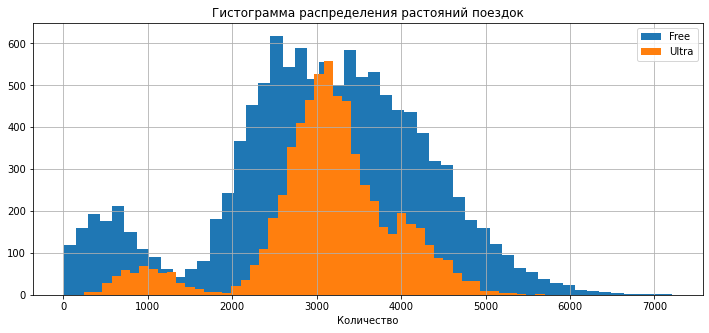

In [64]:
# Код ревьюера
plt.figure(figsize = (12, 5))
go_free['distance'].hist(bins = 50, label = 'Free')
go_ultra['distance'].hist(bins = 50, label = 'Ultra')
plt.legend()
plt.xlabel('Расстояние, м')
plt.xlabel('Количество')
plt.title('Гистограмма распределения растояний поездок')
plt.show()

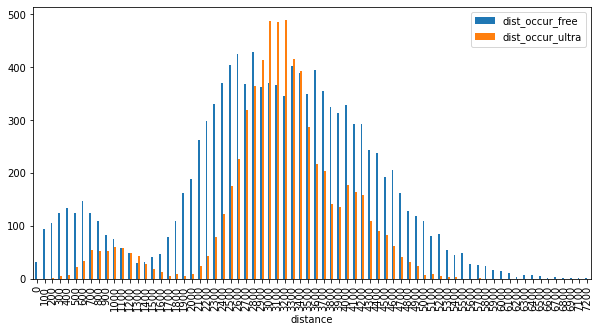

In [65]:
distance_group.plot.bar(figsize=(10,5))
plt.show()

... или лучше даже так.

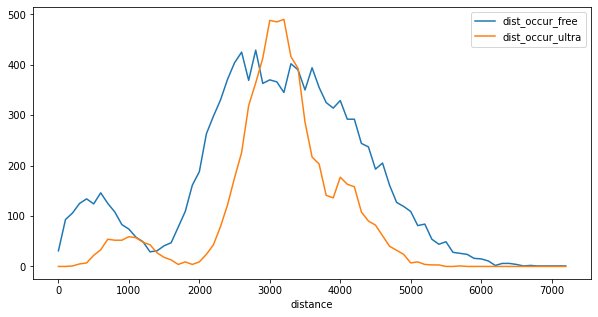

In [66]:
distance_group.plot.line(figsize=(10,5))
plt.show()

Видим:

1. По виду распределения принципиально друг от друга и от общего распределения не отличаются: вид распределения очень напоминает "околонормальное распределение" с центром около 3100 метров с наложением на него в диапазоне малых расстояний еще одного похожего по форме, но меньшего распределения с центром около 700 метров.        
2. Основное отличие между группами - это то, что распределение дальности поездок для клиентов с подпиской "ультра" имеет более выраженный пик и около полутора раз меньшее стандартное отклонение.     
Это скорее всего объясняется тем, что клиенты оформляющие подписку представляют куда (и соответственно на какое расстояние) они будут есздить на самокате, а распределение расстояний для клиентов без подписки "более случайное", то есть имеет большую дисперсию.         
3. Максимальная дальность для клиентов с подпиской "ультра" существенно меньше, чем для клиентов без подписки (5700 против 7200). Это подтверждает наш вывод, сделанный ранее, что поездки на дальность более 5 км. скорее случайность, нежели практика.
4. Кроме того минимальная дистанция для клиентов с подпиской равна 200 метров, а не равна нулю. Это по всей видимости занчит, что подписку оформляют люди, которые уже попробовали ездить на самокате (вполне возможно компании GoFast) и варианта "попробовал поехать, не получилось - бросил" у них не бывает.

Сделаем аналогичное построение для длительности поездок.

Сначала создадим датафрейм - заготовку.      

In [67]:
# Создадим пустой датафрейм - заготовку      
duration_group = pd.DataFrame()

# Зададим в нем диапазон длительностей от 0 до максимума с шагом 1 минуту
duration_group['duration'] = round(go_all['duration'].astype(int), 0).unique()
duration_group = duration_group.sort_values('duration')

duration_group.describe()  # Проверка: посмотреть глазами что получается

,duration
count,40.000000
mean,20.475000
std,11.734209
min,0.000000
25%,10.750000
50%,20.500000
75%,30.250000
max,40.000000


Значения от 0 до максимума поминутно без пропусков (строк 40 и максимум 40 минут). Датафрейм создан.     

Теперь отдельно для каждой группы посчитаем встречаемость разных длительностей.      

In [68]:
duration_free = round(go_free['duration'].astype(int), 0).value_counts()

duration_free = duration_free.reset_index()
duration_free.columns = ['duration','dur_occur_free']
duration_free = duration_free.sort_values('duration')

duration_free.describe()  # Проверка: посмотреть глазами что получается

,duration,dur_occur_free
count,34.000000,34.000000
mean,17.470588,340.235294
std,10.009799,247.667551
min,0.000000,33.000000
25%,9.250000,104.000000
50%,17.500000,294.500000
75%,25.750000,599.750000
max,34.000000,721.000000


In [69]:
duration_ultra = round(go_ultra['duration'].astype(int), 0).value_counts()

duration_ultra = duration_ultra.reset_index()
duration_ultra.columns = ['duration','dur_occur_ultra']
duration_ultra = duration_ultra.sort_values('duration')

duration_ultra.describe()  # Проверка: посмотреть глазами что получается

,duration,dur_occur_ultra
count,38.000000,38.000000
mean,21.500000,171.052632
std,11.113055,170.780553
min,3.000000,1.000000
25%,12.250000,25.000000
50%,21.500000,99.500000
75%,30.750000,300.500000
max,40.000000,488.000000


Значения встречаемости для каждой группы посчитаны и сохнарены в соответствующих датафреймах.     

Теперь создадим единый датафрейм, объединив все три на основе столбца 'duration'.      

In [70]:
duration_group = duration_group.merge(duration_free, on= 'duration', how='outer')
duration_group = duration_group.merge(duration_ultra, on= 'duration', how='outer')

duration_group = duration_group.set_index('duration')


display(duration_group.head(5))  # Проверка: посмотреть глазами что получается
duration_group.info()

,dur_occur_free,dur_occur_ultra
duration,,
0,95.0,NaN
2,33.0,NaN
3,54.0,1.0
4,86.0,9.0
5,115.0,28.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 40
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dur_occur_free   34 non-null     float64
 1   dur_occur_ultra  38 non-null     float64
dtypes: float64(2)
memory usage: 960.0 bytes


Датафреймы объединили в один.     

Теперь заменим пропуски в данных на нули (поскольку если данных нет, то это значит поездок нет то есть 0) ...      

In [71]:
duration_group = duration_group.fillna(0)
duration_group['dur_occur_ultra'] = duration_group['dur_occur_ultra'].astype(int)

display(duration_group.head(5))  # Проверка: посмотреть глазами что получается
duration_group.info()

,dur_occur_free,dur_occur_ultra
duration,,
0,95.0,0
2,33.0,0
3,54.0,1
4,86.0,9
5,115.0,28


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 40
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dur_occur_free   40 non-null     float64
 1   dur_occur_ultra  40 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 960.0 bytes


... и выведем как и хотели диаграмму встречаемости различных дальностей поездок для обеих групп (линиями).    

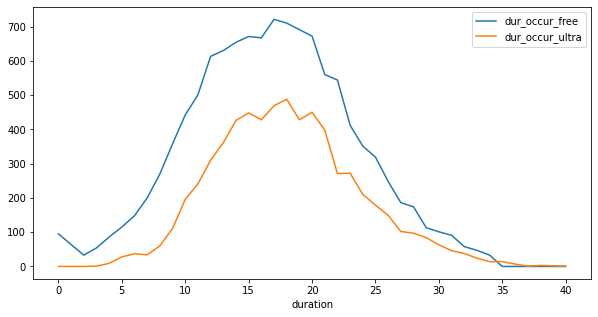

In [72]:
duration_group.plot.line(figsize=(10,5))
plt.show()

Видим:

1. Так же как и с растояниями - по виду распределения принципиально друг от друга и от общего распределения не отличаются и похожи на "нормальные".       
2. Распределение по группе клиентов с подпиской "ультра" ниже по пику и примерно пропорционально ниже по стандартному отклонению. С несколько более высоким средним и медианой (21.5 минуты против 17.5): похоже подписчики ездят немного более спокойно, нежели "разовые" пользователи.      
3. Максимальная длительность для клиентов с подпиской "ультра" даже несколько больше (но не значительно), чем для клиентов без подписки (40 минут против 34-х). 
4. Кроме того минимальная длительность для клиентов с подпиской равна 3 минутам (против нуля у разовых пользователей), что подтверждает наше предположение, сделанное на основе данных по расстояниям: всей видимости значит, что подписку оформляют люди, которые уже попробовали ездить на самокате.

## Шаг 5. Подсчёт выручки

### 5.1 Создать датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найти суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

Все данные для проведения расчетов должны быть в датафрейме 'go_all'.      

Посмотрим

In [73]:
go_all.head(5)

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8


Чтобы рассчитывать что-то для каждого клиента нам понадобится рассчитывать параметры с адресацией на конкретного клиента  - для этого есть столбец 'user_id';    
чтобы рассчитывать помесячно нам нужно указание на месяц - есть столбец 'month';         
чтобы найти суммарное расстояние нужны данные о количестве поездок и дальности каждой поездки - для этого подойдет столбец 'distance';
аналогичная ситуация с рассчетом суммарного времени - нам нужен будет столбец 'duration'.
Возможно есть смысл остальные столбцы из датафрейма  'go_all' тоже взять "в нагрузку" - они могут понадобится в дальнейших рассчетах.     
Однако столбец 'date' с конкретными датами поездок нам вряд ли понадобится (поскольку агрегация будет помесячная, а столбец "месяц" у нас есть. Мы не будем переносить этот столбец в новый датафрейм.      
Зато нам зато нужы будут данные с количеством поездок. Поэтому наверное есть смысл сразу создать столбец 'rides' отражающий количество поездок. Пока нет агрегации он бедет везеде равен единице (одна строка - одна поездка)

Создадим столбец 'rides'

In [74]:
go_all['rides'] = 1

go_all.head(10)  # Проверка: посмотреть глазами что получается 

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,rides
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4,1
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8,1
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8,1
5,1,Кира,22,Тюмень,ultra,6,0,199,2770.890808,16.650138,2021-10-09,10,1
6,1,Кира,22,Тюмень,ultra,6,0,199,3039.020292,14.927879,2021-10-19,10,1
7,1,Кира,22,Тюмень,ultra,6,0,199,2842.118050,23.117468,2021-11-06,11,1
8,1,Кира,22,Тюмень,ultra,6,0,199,3412.690668,15.238072,2021-11-14,11,1
9,1,Кира,22,Тюмень,ultra,6,0,199,748.690645,15.041884,2021-11-22,11,1


Теперь попробуем сделать аггрегирование сначала по параметру месяца, а затем по user_id и затем       
заполним столбцы датафрейма 'go_all_aggr' значениями из 'go_all' с использованием метода .agg():        
создадим столбец  и заполним его значениями из столбца 'distance' методом .agg('count'),        
для столбцов 'rides', 'distance' и 'duration' методом .agg('sum'),      
а для столбцов со "стационарными" данными  - 'user_id', 'name', 'age', 'city', 'minute_price', 'start_ride_price', 'subscription_fee' и 'month' примерим метод .agg('first')

Округлим длительность каждой поездки в большую сторону до минуты.

In [75]:
go_all['duration'] = go_all['duration'].apply(np.ceil)

go_all['duration']  # Проверка: посмотреть глазами что получается

0        26.0
1        16.0
2         7.0
3        19.0
4        27.0
         ... 
18063    20.0
18064    22.0
18065    19.0
18066    17.0
18067    16.0
Name: duration, Length: 18068, dtype: float64

Длительности каждой поездки округлены в большую сторону до минуты.

Теперь создадим словарь для метода агрегирования .agg() оставив те столбцы, которые нам нужны и сопоставив им функции, которыми мы собираемся аггрегировать данные (что где - описано выше)

In [76]:
dict_for_agg_keys = list(go_all.columns)
dict_for_agg_keys.remove('date')
dict_for_agg_keys.remove('user_id')
dict_for_agg_keys.remove('month')

dict_for_agg_values = ['first', 'first', 'first', 'first', 'first', 'first', 'first', 'sum', 'sum', 'sum']

dict_for_agg = dict(zip(dict_for_agg_keys, dict_for_agg_values))

dict_for_agg  # Проверка: посмотреть глазами что получается

{'name': 'first',
 'age': 'first',
 'city': 'first',
 'subscription_type': 'first',
 'minute_price': 'first',
 'start_ride_price': 'first',
 'subscription_fee': 'first',
 'distance': 'sum',
 'duration': 'sum',
 'rides': 'sum'}

Создадим датафрейм 'go_all_aggr' с агрегированными данными

In [77]:
go_all_aggr = go_all.groupby(['month', 'user_id']).agg(dict_for_agg).reset_index()

go_all_aggr  # Проверка: посмотреть глазами что получается

,month,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,rides
0,1,1,Кира,22,Тюмень,ultra,6,0,199,7027.511294,42.0,2
1,1,3,Алексей,20,Москва,ultra,6,0,199,3061.777147,13.0,1
2,1,5,Адель,28,Омск,ultra,6,0,199,3914.646990,13.0,1
3,1,7,Игорь,23,Омск,ultra,6,0,199,6478.080979,28.0,2
4,1,12,Марк,27,Тюмень,ultra,6,0,199,3577.151148,33.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11326,12,1525,Ирина,21,Омск,free,8,50,0,4597.854350,34.0,1
11327,12,1526,Александра,23,Омск,free,8,50,0,3644.121544,23.0,1
11328,12,1528,Анна,25,Пятигорск,free,8,50,0,3998.569324,11.0,1
11329,12,1532,Алексей,26,Тюмень,free,8,50,0,6111.889853,42.0,2


Датафрейм с аггрегированными данными создан, данные (выборочно проверенные по Кире) выглядят корректно.

### 5.2 В этот же датафрейм добавить столбец с помесячной выручкой, которую принёс каждый пользователь. 

Судя по описанию выручка должна считаться следующим образом:      
для клиентов без подписки ('free') - 50 рублей ( столбец 'start_ride_price') * на количество поездок в месяц ( т.е. на 'rides') + 8 рублей  ( столбец 'minute_price') * на суммарную длительность поездок в месяц ( т.е. на 'duration');       
для клиентов с подпиской ('ultra') - 199 рублей в месяц ( столбец 'subscription_fee') + 6 рублей ( столбец 'minute_price') * на суммарную длительность поездок в месяц ( т.е. на 'duration').    
Поскольку в соответствующих столбцах с тарифами в правильных местах стоят правильные цифры (включая нули) - то формула универсальная: 'start_ride_price' * 'rides' + 'minute_price' * 'duration' + 'subscription_fee'.      
Отдельный вопрос, не озвученный в описании - вопрос по округлению (точнее два вопроса):        
нужно ли округлять время до целого значения минут в большую сторону ( что насколько нам известно соответствует общепринятой практике) или не нужно. Поскольку в тех. задании этого требования нет - время округлять не будем;    
а вот полученную сумму на наш взгляд есть смысл округлить до целых копеек.

Создадим новый столбец 'revenue' и заполним его данными, рассчитывая стоимоть по формуле, изложенной выше.

In [78]:
go_all_aggr['revenue'] = 0.0

go_all_aggr.head(5) # Проверка: посмотреть глазами что получается 

,month,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,rides,revenue
0,1,1,Кира,22,Тюмень,ultra,6,0,199,7027.511294,42.0,2,0.0
1,1,3,Алексей,20,Москва,ultra,6,0,199,3061.777147,13.0,1,0.0
2,1,5,Адель,28,Омск,ultra,6,0,199,3914.646990,13.0,1,0.0
3,1,7,Игорь,23,Омск,ultra,6,0,199,6478.080979,28.0,2,0.0
4,1,12,Марк,27,Тюмень,ultra,6,0,199,3577.151148,33.0,1,0.0


In [79]:
go_all_aggr['revenue'] = go_all_aggr['minute_price'] * go_all_aggr['duration'] + \
                         go_all_aggr['start_ride_price'] * go_all_aggr['rides'] + \
                         go_all_aggr['subscription_fee']

go_all_aggr['revenue'] = round(go_all_aggr['revenue'], 2 )                                             
 
go_all_aggr.head(5) # Проверка: посмотреть глазами что получается 

,month,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,rides,revenue
0,1,1,Кира,22,Тюмень,ultra,6,0,199,7027.511294,42.0,2,451.0
1,1,3,Алексей,20,Москва,ultra,6,0,199,3061.777147,13.0,1,277.0
2,1,5,Адель,28,Омск,ultra,6,0,199,3914.646990,13.0,1,277.0
3,1,7,Игорь,23,Омск,ultra,6,0,199,6478.080979,28.0,2,367.0
4,1,12,Марк,27,Тюмень,ultra,6,0,199,3577.151148,33.0,1,397.0


In [80]:
# Код ревьюера
go_all_aggr.groupby('subscription_type')['revenue'].mean()

subscription_type
free     328.641365
ultra    362.792191
Name: revenue, dtype: float64

Помесячная выручка посчитана в разрезе клиентов, цифры похожи на правду.

Посчитаем еще общую выручку компании по всем клиентам в месяц.

In [81]:
revenue_month_user = pd.DataFrame()
revenue_month_user[['month','user_id','revenue']] = go_all_aggr[['month','user_id','revenue']]
revenue_month_user_mean= revenue_month_user.groupby(['month'])['revenue'].agg('mean')

revenue_month_user_mean  # Проверка: посмотреть глазами что получается

month
1     341.371717
2     328.910532
3     346.451681
4     348.345200
5     344.851738
6     340.403242
7     345.067227
8     343.150685
9     346.606223
10    342.410423
11    336.217822
12    342.903260
Name: revenue, dtype: float64

In [82]:
print(round(revenue_month_user_mean.mean(),0))
print(round(revenue_month_user_mean.min(),0))
print(round(revenue_month_user_mean.max(),0))

342.0
329.0
348.0


Средняя выручка на клиента в месяц равна 342 рублей.       
Разброс значений - от 329 до 348 рублей.

Посчитаем еще общую выручку компании по всем клиентам в месяц.

In [83]:
revenue_month_tot = pd.DataFrame()
revenue_month_tot[['month','revenue']] = go_all_aggr[['month','revenue']]
revenue_month_total= revenue_month_tot.groupby('month').agg('sum')

revenue_month_total  # Проверка: посмотреть глазами что получается

,revenue
month,
1,337958.0
2,290428.0
3,329822.0
4,322916.0
5,337265.0
6,335978.0
7,328504.0
8,325650.0
9,323037.0


Ну и средняя суммарная выручка в месяц.

In [84]:
print( round(revenue_month_total['revenue'].mean(), 0) )
print( round(revenue_month_total['revenue'].min(), 0) )
print( round(revenue_month_total['revenue'].max(), 0) )

323220.0
290428.0
337958.0


Средняя в месяц выручка сервиса составляет 323220 рубля. Разброс значений - от 290428 (в феврале) до 337958 рублей (в январе).

## Шаг 6. Проверка гипотез
### Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

### 6.1 Проверить, тратят ли пользователи с подпиской больше времени на поездки?

Из постановки вопроса нет однозначного понимания что в точности нужно  проверить.    
Возможны минимум два варианта постановки задачи:      
1. Проверить тратят ли пользователи с подпиской в среднем больше времени на одну поездку;       
либо                
2. Проверить находятся ли пользователи с подпиской в среднем больше времени за рулем самоката в месяц (с учетом возможно большего количества поездок)

Поскольку по прочтении непонятно какой именно вариант имеется ввиду - разберем и проверим оба варианта. 

Начнем с первого варианта вопроса: действительно ли длительность поездки для категории подписчиков "ultra" в среднем больше, чем для разовых пользователей "free"

Мы ранее уже разделяли данные о поездках из датафрейма 'go_all' на два датафрейма в зависимости от подписки - 'go_free' (поездки пользователей без подписки) и 'go_ultra' (поездки клиентов с подпиской "ультра").      
На основе этих данных легко получить основные статистические данные по длительности поездок в каждой группе и посмотреть.

Посмотрим

In [85]:
go_all['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

In [86]:
go_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [87]:
go_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Отчасти мы уже смотрели эти параметры, когда анализировали распределения встречаемости дазличных длительностей для этих групп пользователей. Так что возможно часть выводов будет повторяться и подтверждаться.

Итак, видим:

1. Поездки клиентов с подпиской "ультра" составляют 36% от всех поездок пользователей сервиса ( 6500 из 18068). Соответственно 64% поездок пользователей, которые уже пользуются сервисом, но не имеют подписки ( 11568 ) - хороший резерв для расширения числа подписчиков.      
2. Распределение по группе клиентов с подпиской "ультра" имеет несколько более высокую среднюю и медианую длительность поездки нежели пользователи без подписки - 18.5 минуты против 17.4 для среднего и 18.5 минуты против 17.4 для медианы. 
3. Стандартное отклонение в группе подписчиков "ультра" на 12% ниже, чем у "разовых" пользователей (5.57 минут против 6.32).

Исходя из выводов выше, (как мы отмечали ранее) - похоже, что подписчики ездят немного более спокойно, нежели "разовые" пользователи. То есть тратят больше времени на поездки.         
Однако разница невелика и возникает вопрос насколько она статистически значима.    
Нужно так-же иметь ввиду, что выборки для подписчиков и разовых пользователей разные по размеру и дисперсии у них никак не могут считаться равными.

Поэтому попробуем проверить гипотезу о том, что средние длительности поездки для совокупностей данных подписчиков и разовах пользователей одинаковы с односторонней альтернативной гипотезой, что длительность поездки для подписчиков значимо меньше, чем для разовых пользователей.     
Будем считать, что совокупности независимы друг от друга (строго говоря это не совсем так, поскольку и одни и другие пользуются услугами одной и той же компании, одними и теми же самокатами с одними и теми же характеристиками и проблемами и т.д.; но в поездке каждый ездок свободен и поэтому допущение считаем валидным).       
Применим функцию st.ttest_ind() для столбцов  'duration' датафреймов array_1 = go_ultra (подписчики) и array_1 = go_free (разовые пользователи).   
При этом, поскольку go_ultra идет первым массивом, а альтернативная гипотеза у нас, что среднее у go_ultra больше - параметр alternative выставим в положение 'greater'.       
Кроме того, поскольку, как мы отметили выше, параметры выборок заметно отличаются и по размеру и по стандартному отклонению - параметр equal_var поставим равным False.         
Уровень статистической значимости alpha возьмем равным 5%. Если р-значение на выходе теста будет меньше нее, то гипотеза о равенстве средних будет отвергнута.

Итак, проверяем следующее:      

- Нулевая гипотеза: средние длительности поездок для обеих категорий равны;     
- Альтернативная односторонняя гипотеза: средняя дяльность поездки для категории подписчиков статистически значимо больше средней длительности поездки для категории разовых пользователей.

In [88]:
alpha = 0.05

results = st.ttest_ind( go_ultra['duration'], go_free['duration'], equal_var = False, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


Вывод:

Пока наши предположения подтверждаются ( в смысле не опровергаются):       
Гипотеза о том, что средние длительности поездок для обеих категорий равны была отвергнута в пользу гипотезы о том, что средняя длительность поездки для категории подписчиков статистически значимо больше средней длительности поездки для категории разовых пользователей. 

Теперь попробуем ответить на вторую возможную формулировку этого же вопроса (и протестировать гипотезу об этом): проводят ли пользователи с подпиской в среднем больше времени за рулем самоката в месяц.

Данные о длительности всех поездок каждого клиента за месяц хранятся в датафрейме go_all_aggr.       
Разделим его на два датафрейма в зависимости от подписки так же, как мы ранее уже разделяли данные о поездках из датафрейма 'go_all':  'go_free_aggr' - поездки пользователей без подписки и 'go_ultra_aggr' - поездки клиентов с подпиской "ультра".      
На основе этих данных легко получить основные статистические данные по суммарному времени, проведенному каждым клиентом в поездках по каждой группе.     
Нас будет интересовать столбец 'duration'.

Создадим датафреймы и посмотрим

In [89]:
go_all_aggr['duration'].describe()

count    11331.000000
mean        29.186127
std         16.752464
min          1.000000
25%         17.000000
50%         24.000000
75%         38.000000
max        143.000000
Name: duration, dtype: float64

In [90]:
go_ultra_aggr = go_all_aggr[go_all_aggr['subscription_type'] == 'ultra']

go_ultra_aggr['duration'].describe()

count    4533.000000
mean       27.298698
std        14.710456
min         4.000000
25%        17.000000
50%        23.000000
75%        35.000000
max       126.000000
Name: duration, dtype: float64

In [91]:
go_free_aggr = go_all_aggr[go_all_aggr['subscription_type'] == 'free']

go_free_aggr['duration'].describe()

count    6798.000000
mean       30.444690
std        17.876362
min         1.000000
25%        18.000000
50%        26.000000
75%        40.000000
max       143.000000
Name: duration, dtype: float64

Датафреймы созданы. 

По основным статпараметрам видим:     
1. Распределение по группе клиентов с подпиской "ультра" имеет  меньшее среднее время всех поездок нежели для пользователей без подписки - 26.6 поездки против 29.6.        
2. Стандартное отклонение в группе подписчиков на 18% ниже, чем у "разовых" пользователей (14.4 против 17.5 минут).   

Поскольку в статистических параметрах среднее суммарное время поездок каждого клиента в месяц по группе подписчиков не только не больше, но даже меньше среднего суммарного времени для группы разовых пользователей, по всей видимости проводить тестирование нет смысла.
Проведем его с единственной целью убедится в этом.

Так же как мы делали с длительностью одной поездки, применим функцию st.ttest_ind() для столбцов 'duration' датафреймов array_1 = go_ultra_aggr (подписчики) и array_1 = go_free_aggr (пользователи без подписки).
При этом, параметр alternative выставим в положение 'greater', параметр equal_var поставим равным False.
Уровень статистической значимости возьмем равным 5%.      
По прежнему если р-значение на выходе теста будет меньше нее, то гипотеза о равенстве средних будет отвергнута в пользу гипотезы о том, что среднее суммарное время поездок каждого клиента в месяц по группе подписчиков больше, чем по группе без подписки.

In [92]:
alpha = 0.05

results = st.ttest_ind( go_ultra_aggr['duration'], go_free_aggr['duration'], equal_var = False, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


Вывод:

Как мы и предположили, гипотеза о том, что среднее суммарное время поездок каждого клиента в месяц по группам подписчиков и не-подписчиков не опровергнута.
Это означает, что альтернативная гипотеза о том, что среднее суммарное время поездок каждого клиента в месяц по группе подписчиков больше, чем по группе без подписки - не нашла подтверждения.

Таким образом:

Хотя средняя продолжительность каждой поездки для клиентов с подпиской "ультра" больше, чем для пользователей без подписки, однако средняя суммарная продолжительность всех поездок клиента в месяц для группы клиентов с подпиской "ультра" не больше (а на самом деле - меньше), чем чем для группы пользователей без подписки - за счет меньшего количества поездок в месяц.

По всей видимости клиенты выбирают подписку не из желания увеличить интенсивность поездок или соображений экономии, а из желания получить больший уровень комфорта.


### 6.2 Проверить гипотезу, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров — оптимальное с точки зрения износа самоката.

Данные о каждой поездке для клиентов категории обладателей подписки "ultra" мы уже выделяли в отдельный датафрейм go_ultra.    

Посмотрим на основные статистические параметры столбца 'distance' этого датафрейма. 

In [93]:
go_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

По данным видно, что среднее расстояние, пройденное в каждой поездке для клиентов категории обладателей подписки "ultra" равно 3115,5 метров.    
Это меньше оптимальных с точки зрения износа 3130 метров, однако разница невелика (пол-процента) и вопрос насколько она статистически значима актуален.

Попробуем проверить (нулевую) гипотезу о том, что средняя дальность одной поездки клиента категории обладателей подписки "ultra" равна 3130 метров с (односторонней) альтернативной гипотезой, что эта дальность больше оптимальной.
Соответственно если нулевая гипотеза подтвердится это и будет означать, что средняя дальность не больше оптимальной ( то есть может равна, а может и меньше).

Проверять гипотезу будем применяя функцию st.ttest_1samp для столбца 'distance' датафрейма go_ultra.    
При этом параметр alternative выставим в положение 'greater'.    
Уровень статистической значимости alpha возьмем равным 5%. Если р-значение на выходе теста будет меньше нее, то гипотеза о равенстве (на самам деле - о непревышении) средней дальности поездки оптимальной будет отвергнута.

In [94]:
optimal_distance = 3130  # Оптимальное расстояние с точки зрения износа самоката

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(go_ultra['distance'], optimal_distance, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу: среднее расстояние значимо больше оптимального')
else:
    print('Не получилось отвергнуть нулевую гипотезу: среднее расстояние НЕ больше оптимального')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу: среднее расстояние НЕ больше оптимального


В постановке вопроса значится проверка "что среднее расстояние не превышает 3130 метров".      
Однако для чистоты эксперимента сразу же проверим альтернативную гипотезу "в другую сторону" - о том, что среднее значимо меньше оптимального.

In [95]:
optimal_distance = 3130  # Оптимальное расстояние с точки зрения износа самоката

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(go_ultra['distance'], optimal_distance, alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу: среднее расстояние значимо меньше оптимального')
else:
    print('Не получилось отвергнуть нулевую гипотезу: среднее расстояние НЕ меньше оптимального')

p-значение: 0.08046311521502146
Не получилось отвергнуть нулевую гипотезу: среднее расстояние НЕ меньше оптимального


Вывод:

В ответ на поставленный вопрос о проверке гипотезы,       
что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров — оптимальное с точки зрения износа самоката        
можно утверждать:     
Эта гипотеза статистически значимо подтверждается ( в смысле не опровергается).       
Более того, можно утверждать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не только не превышает оптимальное, но и очень близко к нему. 

### 6.3. Проверить гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Аггрегированн данные ( включая месячную выручку ) для клиентов обеих категорий ( обладателей подписки "ultra" и разовых пользователей без подписки ) мы выделяли в отдельные датафреймы go_ultra_aggr и go_free_aggr.      
Для работы с данными о месячной выручке нас интересует столюец 'revenue' в этих датафреймах.      

Попробуем проверить гипотезу о том, что средняя выручка для категории подписчиков равна средней выручке для категории разовах пользователей с односторонней альтернативной гипотезой, что выручка для категории подписчиков больше средней выручке для категории разовах пользователей.      
Так же, как и с длительностью поездки будем считать, что клиенты обеих категорий абсолютно независимы друг от друга. 

Сначала посмотрим насколько данные столбца 'revenue' в выборках go_ultra_aggr go_free_aggr отличаются по статитическим параметрам

In [96]:
go_ultra_aggr['revenue'].describe()

count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: revenue, dtype: float64

In [97]:
go_free_aggr['revenue'].describe()

count    6798.000000
mean      328.641365
std       183.868330
min        58.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: revenue, dtype: float64

Выборки значительно отличаются и по размеру и по величине стандартного отклонения. Это нужно иметь ввиду.

Применим функцию st.ttest_ind() для столбцов 'revenue' датафреймов array_1 = go_ultra_aggr (подписчики) и array_1 = go_free_aggr (пользователи без подписки).
При этом, поскольку go_ultra_aggr идет первым массивом, а альтернативная гипотеза у нас, что среднее у go_ultra_aggr больше - параметр alternative выставим в положение 'greater'.       
Поскольку, как мы только что проверили, параметры выборок заметно отличаются и по размеру и по стандартному отклонению - параметр equal_var поставим равным False.      
Уровень статистической значимости alpha возьмем равным 5%. Если р-значение на выходе теста будет меньше нее, то гипотеза о равенстве средних будет отвергнута в пользу гипотезы о том, что средняя выручка для категории подписчиков больше средней выручки для категории разовах пользователей.

In [98]:
alpha = 0.05

results = st.ttest_ind( go_ultra_aggr['revenue'], go_free_aggr['revenue'], equal_var = False, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: выручка от подписчиков больше выручки от разовах пользователей')
else:
    print('Не получилось отвергнуть нулевую гипотезу: выручка от подписчиков НЕ больше чем от разовах пользователей')

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу: выручка от подписчиков больше выручки от разовах пользователей


Вывод:

В ответ на поставленный вопрос о том,      
будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки      
можно утверждать:     
Эта гипотеза статистически значимо подтверждается ( в смысле не опровергается ): выручка от подписчиков действительно больше выручки от разовах пользователей. 

### 6.4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест понадобился бы для проверки этой гипотезы?

По моему мнению в данном случае  генеральная совокупность остается одной и той же: клиенты одни и те же, процесс один и тот же, суть обращений тоже практически одна и та же, меняется только ряд технических условий. Получается, что выборки могут считаться зависимыми.     
Поскольку это так - то нужно применять st.ttest_rel() с именами выборок (столбцов по всей видимости) обращений "до" и "после" в качестве аргументов.

### Общие выводы:

##### Были проанализированы данные сервиса аренды самокатов GoFast:     
набор данных о 1534 пользователях из 8 городов включая данные о возрасте клиента и наличии у него подписки;       
данные о используемых ими подписках и тарифах: подписка "ультра" и разовые поездки с конкретными параметрами тарифов на поездки для этих категоррий;    
а также      
данные о 18068 конкретных поездках пользователей: данные о количестве поездок, показатели дальности и длительности каждой поездки с указанием даты. 

Данные были предствлены в трех датасетах. В целом представленная выборка была полна и репрезентетивна. Пропусков нестыковок и возможных ошибок не выявлено. Было выявлено 31 дубликат данных о клиентах, эти дубликаты были устранены. 

Для удобства анализа датафреймы были объединены в один и в этом объединенном датафрейме были созданы столбцы с месяцем поездки и с количеством поездок и данные в нем были отсортированы по месяцам и клинетам.

##### Были проанализированы параметры распределения клиентов в выборке по городам. Было выявлено следующее:    
1. Киенты распределены по восьми городам довольно ровно: в среднем по 191-192 человека в каждом.      
2. Максимальное количество клиентов в Пятигорске - 219, минимальное как ни удивительно - в Москве - 168 человек. Стандартный разброс количества клиентов по городам в пределах 10%.

##### Было проанализировано количество клиентов в выборке с подпиской и без. Было выявлено, что 
Из 1534 клиентов компании в восьми городах 699 имеют подписку "ультра" и 835 - не имеют подписки.     
Поездки клиентов с подпиской "ультра" составляют 36% от всех поездок пользователей сервиса ( 6500 из 18068).

##### Были проанализированы параметры распределения клиентов в выборке по возростам. Выявлено следующее:       
1. Возраст клиентов колеблется от 12 до 43 лет. Средний возраст практически совпадает с медианным и составляет 26 лет.      
2. Распределение клиентов по возрастам очень напоминает нормальное распределение. Подавляющаяя масса клиентов сосредоточены в возрастных пределах от 19 (Q1) до 33 (Q3) лет.        
3. Максимальное количество клиентов представляют 25-летние - их 145 человек. Минимальное количество - по одному человеку 39-ти и 43-х лет.

##### Были проанализированы параметры распределения клиентов в выборке по дальности поездок. Выявлено следующее:        
1. Средняя дальность поездки составляет 3070 метров, что очень близко к оптимальной дистанции одной поездки с точки зрения износа самоката (3130 метров). При этом медианное значение равно 3133 метра.       
2. Вид распределения дальности поездок действительно очень напоминает наложение двух "околонормальных распределений"
    - одно - по виду немного скошенное нормальное распределение с "центром" около 3200 метров и стандартным отклонением 1024 м.     - и второе тоже по виду маленькое нормальное распределение с центром около 700 метров и стандартным отклонением 447 метров. 
    Наличие такого рода "наложения" может быть объяснением того факта, что медианное знаяение, равное  выше среднего.       
3. Минимальное значение расстояния в 0.85 метра (и пол-минуты длительности) соответствует неудачной попытке поехать. Максимальное пройденное за поездку расстояние равно 7,2 км., что в принципе лежит в пределах возможного для города. Однако следует отметить, что дистанции поездок свыше 5 км. встречаются редко, в единичных количествах, суммарное количество таких поездок (свыше 5 км. каждая) - всего 22.       
4. Основное отличие между группами клиентов с подпиской и без в том, что распределение дальности поездок для клиентов с подпиской "ультра" имеет более выраженный пик и около полутора раз меньшее стандартное отклонение.
Это скорее всего объясняется тем, что клиенты оформляющие подписку представляют куда (и соответственно на какое расстояние) они будут есздить на самокате, а распределение расстояний для клиентов без подписки "более случайное", то есть имеет большую дисперсию.       
5. Максимальная дальность для клиентов с подпиской "ультра" существенно меньше, чем для клиентов без подписки (5700 против 7200). Минимальная дистанция для клиентов с подпиской равна 200 метров, а не равна нулю. Это по всей видимости занчит, что подписку оформляют люди, которые уже попробовали ездить на самокате (вполне возможно компании GoFast) и варианта "попробовал поехать, не получилось - бросил" у них не бывает.

##### Были проанализированы параметры распределения клиентов в выборке по длительности поездок. Выявлено следующее:       
1. Длительности поездок хорошо соответствуют дальности поездки - при средней скорости 10.4 км/ч, скорости по всей линейке от нижнего квартиля и до максимума отличаются всего максимум на 0.2 км/ч.       
2. Вид распределения длительности поездок очень напоминает классическое "нормальное" распределение. Тем не менее в нижней части распределения присутствует выброс, который соответствует аналогичному выбросу, обнаруженному нами на диаграмме расстояний. Это подтверждает нашу гипотезу о том, что что поездки делятся на две отличные друг от друга категории: короткие (до километра) и дальние (от полутора до пяти км.).            
3. Минимальное значение длительности в пол-минуты (и расстоянием в 0.85 метра) соответствует неудачной попытке поехать.  Максимальная длительность поездки в 40 минут хорошо соответствует максимальной дальности в 7 км., так же, как и с дляительностями долгих поездок единицы.         
4. Распределения для клиентов с подпиской и без принципиально друг от друга и от общего распределения не отличаются и похожи на "нормальные". При этом распределение по группе клиентов с подпиской "ультра" ниже по пику и примерно пропорционально ниже по стандартному отклонению. С несколько более высоким средним и медианой (21.5 минуты против 17.5): похоже подписчики ездят немного более спокойно, нежели "разовые" пользователи.        
5. Максимальная длительность для клиентов с подпиской даже несколько больше (но не значительно), чем для клиентов без подписки (40 минут против 34-х). Минимальная же длительность для клиентов с подпиской равна 3 минутам (против нуля у разовых пользователей), что подтверждает наше предположение, сделанное на основе данных по расстояниям: всей видимости значит, что подписку оформляют люди, которые уже попробовали ездить на самокате.

##### Была посчитана ежемесячная выручка сервиса. Выявлено следующее:       
1. Средняя выручка на одного клиента в месяц равна 336 рублей; зазброс значений - от 323 до 342 рублей.        
2. Средняя общая выручка со всех клиентов в месяц составляет 317752 рубля. Разброс значений - от 285610 до 332290 рублей. 

##### Было проверено, тратят ли пользователи с подпиской больше времени на поездки. Выявлено следующее:      
1. Средняя продолжительность каждой поездки для клиентов с подпиской "ультра" больше, чем для пользователей без подписки,    
2. Однако средняя суммарная продолжительность всех поездок клиента в месяц для группы клиентов с подпиской "ультра" не больше (а на самом деле - меньше), чем чем для группы пользователей без подписки - за счет меньшего количества поездок в месяц.

##### Была статистически значимо подтверждена гипотеза      
о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров - оптимального с точки зрения износа самоката. Более того, можно утверждать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не только не превышает оптимальное, но и очень близко к нему.

##### Так-же была статистически значимо подтверждена гипотеза       
о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.



#### Анализ провел Александр Кийко.

<div class="alert-success" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера ✔️</b>

Хороший вывод, отражающий все основные результаты исследования. 👌

</div>

## Шаг 7 (необязательное задание). Распределения

### 7.1 Отделу маркетинга GoFast поставили задачу: 
#### Нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
#### Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. 
#### Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. 
#### Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов
.

Прежде всего - относительно того, каким распределением может описываться этот процесс: 

В поставновке задачи       
речь идет о принципиально дискретной случайной величине (количество подписок),      
условия и процедура проведения акции одинаковы для всех клиентов (раздаются одинаковые промокоды с одинаковыми условиями продления) и  
каждый клиент принимает решение о продлении или непродлении независимо от других клиентов (хотя кто-то из них может общаться между собой и согласовывать свое решение, но мы здесь пренебрежем этими возможностями)       
Таким образом получается, что мы имеем дело со счетным количеством одинаковых и независимых друг от друга испытаний Бернулли (продлил/не продлил), а такой прочесс описывается биномиальным распределением, вид которого теоретически задается двумя параметрами - количеством экспериментов и вероятностью одного эксперимента.      
В нашем случае вероятность каждого отдельного эксперимента задана извесным из прошлой практики процентом продливших подписку (10%). То есть вероятность "положительного исхода" одного эксперимента в нашем случае равна 0,1.   
На самом деле нам необходимый вид распределения задается параметрами его "хвоста": вероятность, что количество "положительных исходов" в серии будет меньше 100 должна быть равно ~ 5%. При этом эта вероятность будет плавно снижаться от 1 до заданных 5% по мере роста количеством экспериментов и "перевалит" через 5% в сторону понижения.   
Количество же экспериментов (т.е. длину серии ) необходимое для выполнения условия, задающего вид распределения - нам необходимо найти.     

Таким образом задачу можно сформулировать так: для биномиального распределения найти минимальное n = Nmin ( по всей видимости перебирая n от 1 и выше  и взяв первое удовлетворяющее условию) такое, при котором вероятность того, что в этой серии из n экспериментов произойдет не более 100 успехов будет <= 0.05, при том, что для серии n-1 эта вероятность будет > 0.05. То есть       

P =  st.binom.cdf(100,n=Nmin,0.1) <= 0.05 &  st.binom.cdf(100,n=Nmin-1,0.1) > 0.05   

Исходя из этого и учитывая, что формулы для "прямого" вычисления n очень сложны,  можно предположить, что по всей видимости лучше всего здесь подойдет цикл for, но для него нужен каокй-то ограничитель (верхняя граница перебора). Для  этого ограничим возможное n сверху каким-нибудь разумным ограничением. На наш взгляд разумно предположить, что длина серии в нашем случае должна бы быть по порядку величины - несколько тысяч. По идее длина серии не должна бы превысить 10 тысяч ни при каких разумных обстоятельствах. Возьмем значение количества n=Nmax=10000 за ограничитель количества циклов перебора.  

Попробуем

проверим ограничитель

In [99]:
prob_lim = st.binom.cdf(100,10000,0.1)  # вероятность иметь меньше 100 успехов при количестве экспериментов 10000 
                                        # и вероятности успеха одного эксперимента 0.1

prob_lim

7.18607920577e-312

Векроятность крайне мала, значит ограничитель работает.

Создадим цикл.

In [100]:
prob_each = 0.1 # вероятность успеха каждого эксперимента

prob_threshold = 0.05 # заданный порог вероятности

num_success = 100 # порог количества успехов

num_threshold = 10000 # порог количества экспериментов

for n in range(0, num_threshold):
    prob_n = st.binom.cdf(100,n,prob_each)
    if n == num_threshold:
        print( 'количество необходимых промокодов не меньше', n)
        break
    elif prob_n <= 0.05:
        print( 'количество необходимых промокодов равно', n)
        break
    else:
        continue


количество необходимых промокодов равно 1172


Итак по нашим предположениям необходимо разосталть не менее 1172 промокодов.     
Это значение должно быть минимальным, то есть для 1172 промокодов вероятность того, что подписку продлят меньше 100 клиентов будет равна или чуть меньше 5%, а эта же вероятность для 1171 промокода будет чуть выше 5%.

На всякий случай проверим.

In [101]:
print(st.binom.cdf(100,1172,0.1))
print(st.binom.cdf(100,1171,0.1))

0.04954795210203071
0.0505235199072141


Проверка пройдена.  

Таким образом минимальное количество промокодов,     
которое необходимо разостать, чтобы количество клиентов, продливших подписку после месяца использования промокода в результате не было меньше 100 с вероятностью больше 5%       
равно 1172 промокода.

Построим график биномиального распределения для серии из 1172 экспериментов, в которых вероятность успеха каждого равна 10%.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


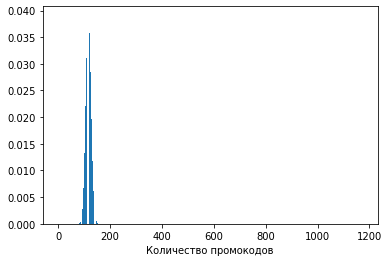

In [102]:
n = 1172 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n+1):
    current_value = st.binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n+1), distr)
plt.xlabel('Количество промокодов')
plt.show()

Найдем "центр" этого распределения...

In [103]:
st.binom.mean(1172, 0.1)

117.2

... и его стандартное отклонение.

In [104]:
st.binom.std(1172, 0.1)

10.270345661174215

Видим очень узкое распределение с центром 117.2 и стандартным отклонением в 10.3 

### 7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

В данном случае мы так-же имеем дело с биномиальным распределением,      
однако количество экспериментов в нем очень большое и по всей видимости в этом случае лучше сделать аппроксимацию этого биномиального распределения нормальным непрерывным распределением.    
Чтобы мы могли смело это делать должно выполняться условие: диапазон мат ожидание плюс/минус три сигмы должен лежать внутри промежутка от нуля до n ( в данном случае - миллиона).   

Проверим

In [105]:
# Запишем параметры нашего распределения
n = 1000000
p = 0.4

mu = n*p
sigma = sqrt(n * p * (1 - p))

# выведем значения мю плюс минус три сигмы и посмотрим 
print(mu)
print(sigma)
print(round( mu - 3*sigma, 0))
print(round( mu + 3*sigma, 0))

400000.0
489.89794855663564
398530.0
401470.0


Видим, что условие выполняется.      
Значит можем делать аппроксимацию нормальным распределением.

Построим график этого роспределения.

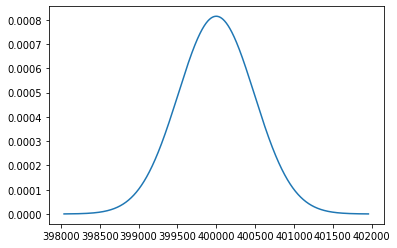

In [106]:
# Запишем параметры нашего распределения
n = 1000000
p = 0.4

mu = n*p
sigma = sqrt(n * p * (1 - p))

# Зададим диапазон значений оси абсцисс для нашего распределения
x = np.arange(mu-4*sigma, mu+4*sigma, 1)

# Построим график
plt.plot(x, st.norm.pdf(x, mu, sigma))
plt.show()

Оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.     
Эта вероятность можно оценить как вероятность левого "хвоста" аппроксимирующего нормального распределения st.norm(mu, sigma),    а эта вероятность в свою очередь рассчитывается функцией cdf().

Проделаем этот расчет.

In [107]:
# Запишем параметры нашего распределения
n = 1000000
p = 0.4

mu = n*p
sigma = sqrt(n * p * (1 - p))

threshold = 399500

# Зададим аппроксимирующее распределени
distr = st.norm(mu, sigma)

# Вычислим вероятность левого от порога "хвоста" этого распределения, это и будет искомая нами вероятность
res = distr.cdf(threshold)

# Выведем результат
res

0.15371708296369768

Таким образом наша оценка вероятности того, что уведомление откроют не более 399,5 тыс. пользователей равна 15,4%.           

#### Проект выполнил Александр Кийко.
##### a.m.kiyko@yandex.ru

<div style="border:solid steelblue 3px; padding: 20px; border-radius: 10px">

<h5><b>🏁 Общий комментарий ревьюера:</b></h5>

Александр, у тебя получился очень сильный проект, ты очень подробно и правильно выполнил все задания. 

Отличная работа!👏👏👏 

Успехов в дальнейшем обучении! 🏆</div>